In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import MDS
import warnings
from math import pi, log, e
from sys import float_info as fi

In [4]:
class PAk():
  def __init__(self, data, threshold = 23.928):
    #Initializing data.
    self.data = data
    self.threshold = threshold # = D_thr

    self.d = self.data.shape[1]
    self.nPoints = self.data.shape[0]
    self.__hypersphereVolume = self.__computeUnitaryHypersphereVolume(self.d)
    # ^ This is used to compute the hypervolume in "computeDensities"

    #Initializing useful arrays.
    self.densities = np.zeros(self.nPoints)
    self.distances = self.__computeDistanceMatrix()
    self.clusterArr = np.zeros(self.nPoints)
    self.arrCounter = np.zeros(self.nPoints)

  def __computeDistanceMatrix(self):
    """
    Computes the distance matrix. May throw warnings due to values < 0 in the sqrt.
    This is due to machine precision errors.
    """
    with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      x2 = np.sum(self.data**2, axis=1)
      xx = np.matmul(self.data, self.data.T)
      result = np.nan_to_num(np.sqrt(x2 + x2.reshape(-1, 1) - 2*xx))
    return result

  def __computeUnitaryHypersphereVolume(self,dims):
    """
    From https://www.wikiwand.com/en/Volume_of_an_n-ball#Two-dimension_recurrence_relation.
    Computes the volume of an Hypersphere of dimension 'dims' and radius 1.
    """
    if dims == 0:
      return 1
    elif dims == 1:
      return 2 #*r
    else:
      volMinus2 = self.__computeUnitaryHypersphereVolume(dims-2)
      return (2*pi)/dims * volMinus2 # * r^dims


  def computeDensities(self):
    """
    Computes the Densities with the Point Adaptive KNN.
    """
    dists = self.distances                                                      # Initializes the distance matrix
    order = dists.argsort(axis = 1)                                             # We get the sorted indices by row...
    sortedDists = np.take_along_axis(dists, order, axis = 1)                    # And sort the distances.

    #Auxiliary Variables
    oldVik = 0
    oldK = 1

    #This arrays will be used to contain the densities.
    kArray = np.zeros(self.nPoints)
    vkArray = np.zeros(self.nPoints)

    for rowIndex, _ in enumerate(self.data):                                    # For each point i in the dataset,
      for k in range(2, self.nPoints-1):                                        # Check the kNN:
        radius = sortedDists[rowIndex, k]                                       # The radius of the hypersphere is equal to the already computed distance.
        vik = self.__hypersphereVolume * pow(radius, self.d)                    # then compute the volume.
                                                                                # If j is k+1 NN,
        jIndex = order[rowIndex,k+1]                                            # We then compute the hypervolume between j and j's kNN.
        radiusJ = sortedDists[jIndex, k]
        vjk = self.__hypersphereVolume * pow(radiusJ, self.d)

        # What if vik = 0? Due to machine error or overlapping points:
        vik = fi.min if vik == 0 else vik
        vjk = fi.min if vjk == 0 else vjk


        dki = -2 * k * (log(vik) + log(vjk) - 2 * log(vik+vjk) + log(4))        # The D value is computed following Eq. (3)

        if dki >= self.threshold:                                               # If it goes over the threshold, we break.
          break

        oldK = k
        oldVik = vik

      kArray[rowIndex] = oldK                                                   # We store the k and the volumes...
      vkArray[rowIndex] = oldVik

    # And compute densities (number of neighbors/hypervolume),
    densities = kArray/vkArray
    # And errors (Eq. (5))
    errors = np.sqrt(
        ((4 * kArray) + 2) / ((kArray-1) * kArray)
    ).reshape(-1,1)

    #Finally return.
    self.densities = densities
    return densities, errors, kArray

  def computeDistsDensity(self):
    """
    Function to compute the outlier plot to determine the cluster centers.
    """
    
    #Compute the order of the points based on the densities
    sortedIndices = np.argsort(self.densities)
    #sortedDensities = self.densities[sortedIndices]

    #Initialize the array:
    minDists = np.zeros(self.nPoints)

    #And compute:
    for densIndex, ptIndex in enumerate(sortedIndices):

      #If it is the highest density point: set it as the highest * 1.05
      if densIndex == self.nPoints-1: 
        secondHighest = sortedIndices[densIndex-1]
        minDists[ptIndex] = minDists[secondHighest] * 1.05

      else: #, set it as the minimum distances of the points with greater densities.
        greaterDens = sortedIndices[densIndex+1: self.nPoints]
        minDists[ptIndex] = np.min(self.distances[ptIndex, greaterDens])

    self.minDists = minDists
    return minDists

  def computeDensityPeaks(self, minDists, clusterIndices, tries = 10):
    """
    This computes the density peaks clustering.
    Could be optimized.
    """

    #Sort the distances, and remove the first column (always = 0).
    order = self.distances.argsort(axis = 1)[:,1:]
    #nearestPtsDists = np.take_along_axis(self.distances, order, axis = 0)
    #sortedIndices = np.argsort(self.densities)

    #Initialize failsafe:
    self.arrCounter = np.zeros(self.nPoints)

    # Initialize the cluster centers:
    for clInd, ptInd in enumerate(clusterIndices):
      self.clusterArr[ptInd] = clInd + 1

    #Try to assign the points in "tries" amount of tries
    for t in range(tries):
      for i in range(self.nPoints):
        if self.clusterArr[i] == 0:
          self.__clusterAssignment(i, order)
 

  def __clusterAssignment(self, ptIndex, order):
    """
    This recursively tries to assign clusters.
    This could have been done with references, but pointer
    stuff in python is strange.
    """

    for i in order[ptIndex, :]:
      #Get the i-th nearest neighbor of a point
      nn = self.densities[i]

      # If the density is higher:
      if nn > self.densities[ptIndex]:

        #Try to set the cluster;
        #If NN's cluster index is 0 (not assigned)...
        if self.clusterArr[i] == 0:
          #Assign recursively to the nn (3 tries).
          if self.arrCounter[i] <= 2:
            self.__clusterAssignment(i, order)
          self.arrCounter[i] += 1
        #Then finally set the cluster.
        self.clusterArr[ptIndex] = self.clusterArr[i]


In [42]:
#Generating a test dataset, uniform and gaussian distributions:
nPtsUniform = 1500
nPtsGaussian = 1500
dims = 2
rng = np.random.default_rng(seed=1)
data = np.concatenate((rng.normal((0,0), 1,(nPtsGaussian, dims)),
                       rng.uniform(-5, 5,(nPtsUniform, dims))
                      ), axis = 0)

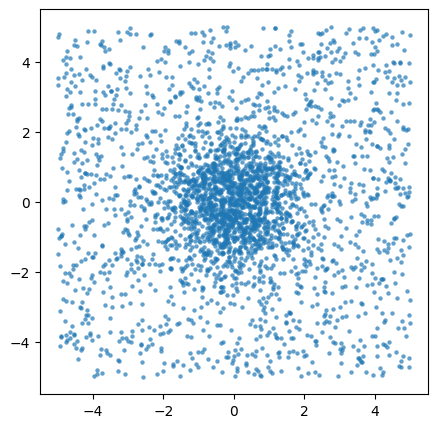

In [43]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
ax.scatter(data[:,0], data[:,1], alpha = 0.7, linewidth = 0, s = 10)

In [44]:
#Try to compute the pak:
pak = PAk(data)
densities, err, k = pak.computeDensities()

#... and the free energy.
freeEnergy = -1 * np.log(densities)

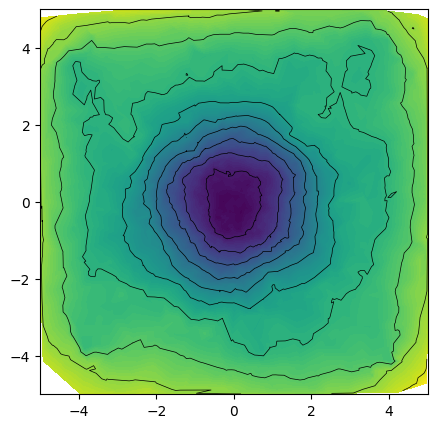

In [45]:
#Plot the contour plot:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
ax.tricontour(data[:,0], data[:,1], freeEnergy, levels=10, linewidths=0.5, colors="k", linestyles = "solid")
ax.tricontourf(data[:,0], data[:,1], freeEnergy, levels=100)

## Let's test PAk:



In [46]:
def twodgauss(data, center, sigma):
    """
    This function defines the ground truth for the next dataset, it's
    a 2d gaussian.
    """
    x = data[:,0]
    y = data[:,1]
    x0 = center[0]
    y0 = center[1]
    A = 1 / (2 * pi * sigma * sigma)
    gausspower = (np.power(x - x0, 2)/(2 * np.power(sigma, 2))) + (np.power(y - y0, 2)/(2 * np.power(sigma, 2)))
    return A * np.power(e, -1 * gausspower)

In [47]:
# We generate data from 9 normal distributions:
nGauss = [300, 1000, 3000]
nSigma = [0.1, 1, 3]
rng = np.random.default_rng(seed=1)
testData = np.array([], dtype=np.int64).reshape(0,2)
trueData = np.array([], dtype=np.int64)

for ptsIndex, pts in enumerate(nGauss):
  for sigmaIndex, sigma in enumerate(nSigma):
    mu = (ptsIndex * 25, sigmaIndex * 25)
    tempData = rng.normal(mu, sigma,(pts, 2))
    
    testData = np.concatenate((testData, tempData), axis = 0)
    trueData = np.concatenate((trueData, twodgauss(tempData, mu, sigma)), axis = 0)


In [48]:
#And apply PAk:
pak2 = PAk(testData)
densities2, err2, k2 = pak2.computeDensities()
freeEnergy2 = -1 * np.log(densities2)
dists2 = pak2.computeDistsDensity()

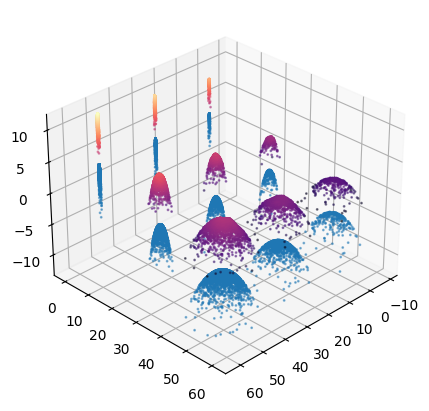

In [49]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection = "3d")
ax.view_init(30,45,0)
ax.scatter(testData[:,0], testData[:,1], np.log(densities2), s = 1, c = np.log(densities2), cmap = 'magma', alpha = .5)
ax.scatter(testData[:,0], testData[:,1], np.log(trueData), s = 1, alpha = .5)

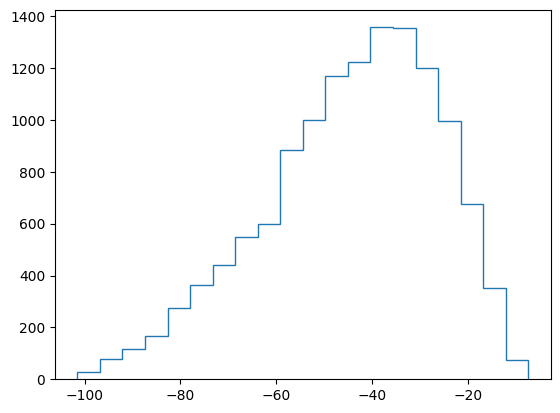

In [110]:
# Generating the pull distribution from the ground truth.
pull = (np.log(trueData) - np.log(densities2)) / err2[:,0]
counts, bins = np.histogram(pull, bins = 20)
plt.stairs(counts, bins)

# Proteins


In [7]:
#trp["temperature [k]"].unique()
#Output:
# array([300.  , 304.  , 308.15, 312.46, 316.92, 321.54, 326.31, 331.23,
#        336.31, 341.54, 346.92, 352.46, 358.15, 364.  , 370.  , 376.15,
#        382.46, 388.92, 395.54, 402.31, 409.23, 416.31, 423.54, 430.92,
#        438.46, 446.15, 454.  , 462.  , 470.15, 478.46, 486.92, 495.54,
#        504.31, 513.23, 522.31, 531.54, 540.92, 550.46, 560.15, 570.  ])
# We only use one temperature at a time.

In [70]:
# From https://www.kaggle.com/datasets/tobiasle/trp-cage-dihedrals;
# PDB: IL2Y
# We create subsets of data from the main csv via Bash (see separate.sh)

trp = pd.read_csv("./data/trp_300.00.csv")
trp = (trp
.drop(trp.columns[41:44], axis = 1)
.drop(["temperature [k]", "time [ps]", "replica id"], axis = 1)
.sample(frac = .25, random_state = 10) # We only use 1/4 of the data.
)
trpArr = np.array(trp)

In [71]:
#Overview of the data
trp.head()

,phi0,phi1,phi2,phi3,phi4,phi5,phi6,phi7,phi8,phi9,...,psi9,psi10,psi11,psi12,psi13,psi14,psi15,psi16,psi17,psi18
995,-1.124,-1.108,-1.233,-1.119,-1.286,-1.052,-1.239,-1.611,1.487,1.209,...,0.431,-1.984,-0.358,-0.333,-0.618,0.546,2.652,2.514,2.317,2.272
20742,-1.157,-1.186,-1.093,-0.855,-1.200,-1.133,-1.283,-1.035,2.218,1.111,...,0.197,-2.321,-0.397,-0.145,-0.322,-0.151,2.369,2.628,2.313,2.284
13175,-1.184,-1.155,-1.085,-1.190,-1.181,-1.056,-1.070,-1.605,2.900,1.128,...,-0.088,-2.528,-0.004,0.002,-0.432,0.210,2.508,2.898,2.506,2.462
12785,-1.023,-1.154,-1.270,-1.418,-1.600,-1.154,-1.516,-1.276,2.132,0.994,...,-0.221,-2.234,-0.090,0.010,0.058,-0.402,2.395,2.972,2.251,2.512
8639,-1.240,-1.394,-1.253,-1.084,-1.310,-1.109,-1.076,-1.602,1.504,1.238,...,0.309,-2.120,-0.522,-0.443,-0.386,0.347,2.760,2.781,2.590,2.762


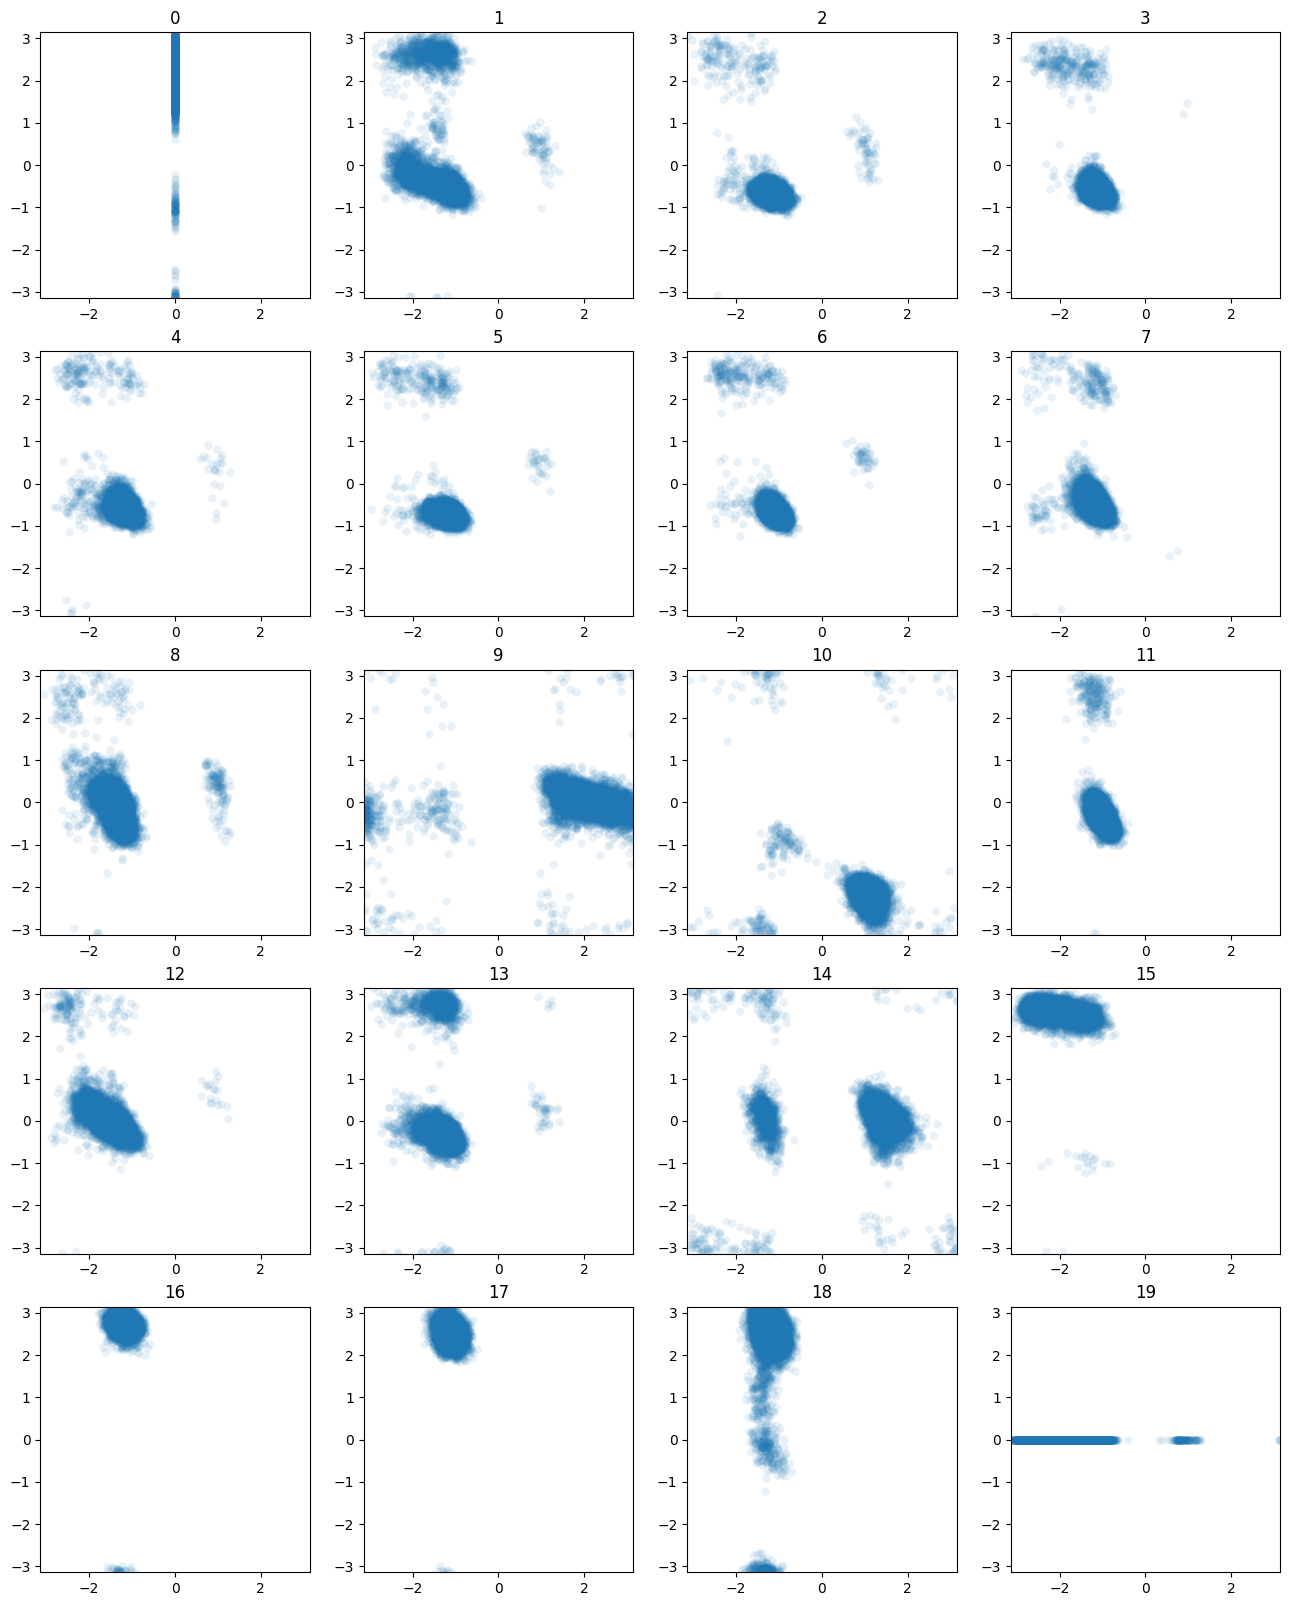

In [52]:
#Plotting the Ramachandran Plots.
#The first and last angles are not given: this creates artifacts in the first and last plots
ramachandran = np.c_[ np.zeros(trpArr.shape[0]), trpArr, np.zeros(trpArr.shape[0]) ]
fig, ax = plt.subplots(5,4, figsize = (16, 20))
ax = ax.reshape(1,-1)[0]
for i, a in enumerate(ax):
  a.set_title(f"{i}")
  a.set_xlim(left=-1 * pi, right=pi)
  a.set_ylim(bottom=-1 * pi, top=pi)
  a.scatter(ramachandran[:, i], ramachandran[:, i+20], alpha = 0.1, linewidth = 0)

In [72]:
pakTrp = PAk(trpArr)
densitiesTrp, errTrp, kTrp = pakTrp.computeDensities()
distsTrp = pakTrp.computeDistsDensity()

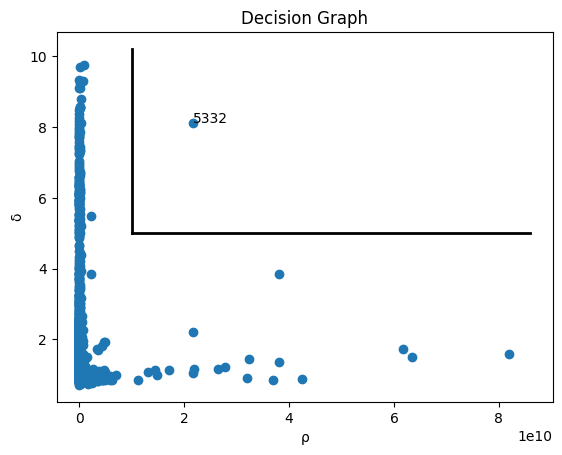

In [73]:
dencutoff = 1e10
distcutoff = 5

plt.scatter(densitiesTrp, distsTrp)
plt.ylabel('δ')
plt.xlabel('ρ')
plt.title("Decision Graph")

bottom, up = plt.ylim()
left, right = plt.xlim()

plt.plot([dencutoff, right], [distcutoff, distcutoff], color="k", linestyle="-", linewidth=2)
plt.plot([dencutoff, dencutoff], [distcutoff, up], color="k", linestyle="-", linewidth=2)

goodpts = []

for i in range(pakTrp.nPoints):
  if distsTrp[i] > distcutoff and densitiesTrp[i] > dencutoff:
    goodpts = goodpts + [i]
    plt.annotate(i, (densitiesTrp[i], distsTrp[i]))

In [54]:
pakTrp.computeDensityPeaks(distsTrp, goodpts)
clustersTrp = pakTrp.clusterArr

In [ ]:
mds = MDS(max_iter=30)
trpMds = mds.fit_transform(trp)

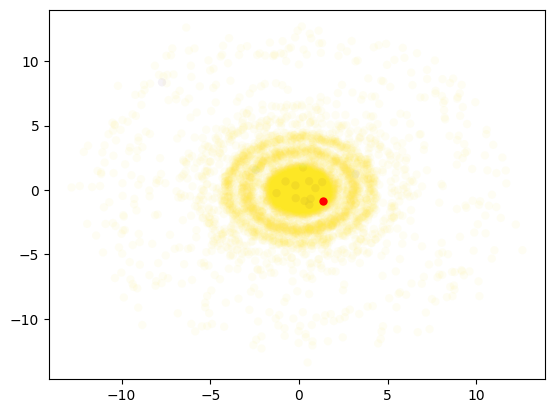

In [39]:
fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(trpMds[:,0], trpMds[:,1], c = clustersTrp, alpha = 0.05, linewidth = 0)
ax.scatter(trpMds[goodpts,0], trpMds[goodpts,1], c = 'r', alpha = 1, linewidth = 0)

In [56]:
# Really rough, this shouldn't be here. But it works.
# To generate commands for pymol
angles = np.rad2deg(trp.iloc[np.argmax(densitiesTrp)])
angnp = np.array(angles)
angnp = np.concatenate([[0], angnp, [0]])
for i in range(20):
    print(f"set_phipsi resi {i+1}, {angnp[i]}, {angnp[i+20]}")

set_phipsi resi 1, 0.0, 101.81460019474729
set_phipsi resi 2, -58.384399323830884, -21.657804655945117
set_phipsi resi 3, -76.1460909728864, -41.99780638308934
set_phipsi resi 4, -64.74423084978302, -45.43555315387428
set_phipsi resi 5, -63.139949023416726, -28.13222774092342
set_phipsi resi 6, -74.82828804408551, -36.72659466788577
set_phipsi resi 7, -57.41037107210849, -39.82056676159221
set_phipsi resi 8, -68.81223119521188, -26.642537473583282
set_phipsi resi 9, -90.24085273310466, 12.433184154338864
set_phipsi resi 10, 103.87724825721824, 7.964113352318444
set_phipsi resi 11, 65.71825910150542, -130.74896884885385
set_phipsi resi 12, -62.452399669259734, -12.433184154338864
set_phipsi resi 13, -100.1530225888679, -7.677634454753032
set_phipsi resi 14, -50.13380707394703, -38.56005961230441
set_phipsi resi 15, 107.71606548459476, -7.333859777674538
set_phipsi resi 16, -125.30586979511104, 153.2662101974952
set_phipsi resi 17, -68.92682275423803, 152.17759038674666
set_phipsi resi 1

![title](./pix/trp1.png)

![title](pix/trp2.png)

In [65]:
#Now with 470.15 K
trp = pd.read_csv("./data/trp_470.15.csv")
trp = (trp
.drop(trp.columns[41:44], axis = 1)
.drop(["temperature [k]", "time [ps]", "replica id"], axis = 1)
.sample(frac = .25, random_state = 0) # We only use a subset.
)
trpArr = np.array(trp)

In [66]:
pakTrp = PAk(trpArr)
densitiesTrp, errTrp, kTrp = pakTrp.computeDensities()
distsTrp = pakTrp.computeDistsDensity()

/tmp/ipykernel_41003/594743944.py:86: RuntimeWarning: divide by zero encountered in divide
  densities = kArray/vkArray
/tmp/ipykernel_41003/594743944.py:89: RuntimeWarning: divide by zero encountered in divide
  ((4 * kArray) + 2) / ((kArray-1) * kArray)


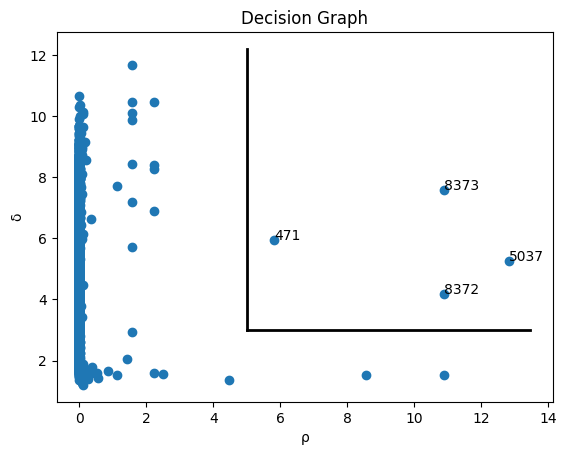

In [69]:
dencutoff = 5
distcutoff = 3

plt.scatter(densitiesTrp, distsTrp)
plt.ylabel('δ')
plt.xlabel('ρ')
plt.title("Decision Graph")

bottom, up = plt.ylim()
left, right = plt.xlim()

plt.plot([dencutoff, right], [distcutoff, distcutoff], color="k", linestyle="-", linewidth=2)
plt.plot([dencutoff, dencutoff], [distcutoff, up], color="k", linestyle="-", linewidth=2)

goodpts = []

for i in range(pakTrp.nPoints):
  if distsTrp[i] > distcutoff and densitiesTrp[i] > dencutoff:
    goodpts = goodpts + [i]
    plt.annotate(i, (densitiesTrp[i], distsTrp[i]))

In [58]:
pakTrp.computeDensityPeaks(distsTrp, goodpts)
clustersTrp = pakTrp.clusterArr

In [59]:
mds = MDS(n_components = 3,max_iter=30)
trpMds = mds.fit_transform(trp)

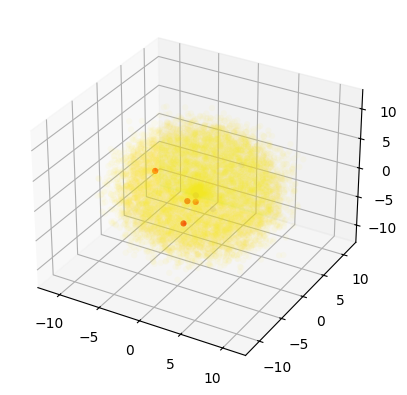

In [69]:
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')

ax.scatter(trpMds[:,0], trpMds[:,1], trpMds[:,2], c = clustersTrp, alpha = 0.05, linewidth = 0)
ax.scatter(trpMds[goodpts,0], trpMds[goodpts,1], trpMds[goodpts,2], c = 'r', alpha = 1, linewidth = 0)
#Pretty much only cluster generated from 8373

In [77]:
# Pymol commands
angles = np.rad2deg(trp.iloc[8373])
angnp = np.array(angles)
angnp = np.concatenate([[0], angnp, [0]])
for i in range(20):
    print(f"set_phipsi resi {i+1}, {angnp[i]}, {angnp[i+20]}")

set_phipsi resi 1, 0.0, 95.11099399171665
set_phipsi resi 2, -70.24462568303893, -23.777748497929164
set_phipsi resi 3, -61.363779858511165, -37.47143980155584
set_phipsi resi 4, -83.3080634120217, -27.731157284331843
set_phipsi resi 5, -61.70755453558966, -8.938141604040842
set_phipsi resi 6, -132.69702535229865, -8.479775367936183
set_phipsi resi 7, -44.28963756361264, -26.298762796504786
set_phipsi resi 8, -144.1561812549151, 174.00728238123102
set_phipsi resi 9, -73.39589355625846, -38.44546805327824
set_phipsi resi 10, -145.9323504198207, -134.07212406061262
set_phipsi resi 11, 82.44862671932546, -115.0499252622693
set_phipsi resi 12, -68.4111607386203, -16.04281826366305
set_phipsi resi 13, -101.92919175377345, 21.772396214971284
set_phipsi resi 14, -74.82828804408551, 162.49083069910145
set_phipsi resi 15, -57.00930061551691, -173.7208034836656
set_phipsi resi 16, -153.95375955165218, 175.7261557666235
set_phipsi resi 17, -83.76642964812635, 140.14547668899937
set_phipsi resi 18

![title](./pix/trp3.png)